# Experiment 01

First Tests from the predictions.

In [1]:
import numpy as np
import pandas as pd
import math

import sys
import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')


def getPeriod2(df, begin, end, resetIndex = False):
    """
    Returns the df in the chosen interval
    
    Object begin: Start date forrmated as 'yyyy.mm.dd'.
    Object   end: End date 'yyyy.mm.dd'.

    returns a dataframe with the historic of the selected period
    """
    
    indexBegin = df[df['date']==begin].index[0]
    indexEnd = df[df['date']==end].tail(1).index[0]
    
    if (resetIndex):
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)].reset_index(drop=True)
    else: 
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)]

In [2]:
def readPrevision(fundo):
    pred = pd.read_pickle(f'../Data/{fundo}_Pred_WithBb.pkl')
    pred = pred.reset_index()
    pred = pred.rename(columns={'timestamp': 'date'})
    pred['date'] = pred['date'].astype(str).str.replace('-', '.', regex=False)
    return pred

In [3]:
dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'

TRAIN_BEGIN = '2020.03.31'
TRAIN_END = '2021.05.31'

TIMES = 10

### Início do sistema

In [9]:
def getDay(df, day):
    return df[df['date']==day]

def buy(value, availableMoney, opr='normal'):
    lotValue = value*100
    quantity = math.floor(availableMoney/lotValue)
    
    amount = quantity*lotValue
    remainingMoney = availableMoney - amount
    
    return remainingMoney, quantity

def sell(value, amount, opr='normal'):
    if(opr == 'normal'):
        return value*amount*100
    else:
        return value*amount*100

## Funções

In [12]:
def runStrategy(df, dailyDf, Money, stopLoss, std, use_uncertainty, uncertainty_threshold):
    size = len(df.index)

    Money = Money
    stopLoss = stopLoss

    orders = []

    for day in range(0,size):
        currentDay =  df.iloc[day].date

        lowPred = df.iloc[day].low_pred*(1+std)
        highPred = df.iloc[day].high_pred*(1-std)
        day_uncertainty = df.iloc[day].uncertainty_mean
        if use_uncertainty and day_uncertainty > uncertainty_threshold:
            continue

        dayDf = getPeriod2(dailyDf, currentDay, currentDay)
        daySize = len(dayDf.index)

        op = 'none'
        quantity = 0
        trade = []

        for i in range(0,daySize):
            currentTime = dayDf.iloc[i]

            if((op == 'buy') and (currentTime.close < opPrice*(1-stopLoss) or currentTime.close >= highPred or i == daySize-1)):
                isStop = False
                if(currentTime.close < opPrice*(1-stopLoss)): isStop = True
                aux = sell(currentTime.close, quantity)
                Money = Money + aux 
                trade = trade + [currentTime.time, 'Sell', currentTime.close, currentTime.close-opPrice,(currentTime.close-opPrice)*100*quantity, isStop, Money, day_uncertainty]
                orders.append(trade)

                quantity = 0
                op = 'none'

            elif((op == 'sell') and (currentTime.close > opPrice*(1+stopLoss) or currentTime.close <= lowPred or i == daySize-1)):
                isStop = False
                if(currentTime.close > opPrice*(1+stopLoss)): isStop = True

                aux = sell(currentTime.close, quantity)
                Money = Money + (opPrice*100*quantity) + ((opPrice*100*quantity) - aux) 
                trade = trade + [currentTime.time, 'Buy', currentTime.close, opPrice-currentTime.close,(opPrice-currentTime.close)*100*quantity, isStop, Money, day_uncertainty]
                orders.append(trade)

                quantity = 0
                op = 'none'

            elif(op == 'none' and i < daySize-1):
                if(currentTime.close <= lowPred):
                    Money, quantity = buy(currentTime.close, Money)
                    opPrice = currentTime.close
                    op = 'buy'

                    trade = [currentTime.date, quantity, currentTime.time, 'Buy', currentTime.close]

                elif(currentTime.close >=  highPred):
                    Money, quantity = buy(currentTime.close, Money)
                    opPrice = currentTime.close
                    op = 'sell'

                    trade = [currentTime.date, quantity, currentTime.time, 'Sell', currentTime.close]
        #print('eday '+str(day)+' money: '+str(Money))
    
    ordersDf = pd.DataFrame(orders)
    if not ordersDf.empty:
        ordersDf.columns = ['date','batches','time_op1','op1','value_op1','time_op2','op2','value_op2', 'profit', 'totalProfit', 'stop','Amount', 'uncertainty']
    tradedDays = ordersDf['date'].nunique() if not ordersDf.empty else 0
    return ordersDf, tradedDays

In [13]:
def calcular_score(finalAmount, acuracia, drawdown, peso_amount=0.6, peso_acuracia=0.3, peso_drawdown=0.2):
    """
    Calcula o Score baseado nos pesos de Final Amount, Acurácia e Maximum Drawdown.
    
    Parâmetros:
    finalAmount (float): O valor final do capital após a execução da estratégia.
    acuracia (float): A porcentagem de acurácia da estratégia.
    drawdown (float): O valor do Maximum Drawdown.
    peso_amount (float): Peso para o Final Amount.
    peso_acuracia (float): Peso para a Acurácia.
    peso_drawdown (float): Peso para o Maximum Drawdown.
    
    Retorna:
    float: O Score calculado.
    """
    # Normalização das métricas
    normalized_finalAmount = finalAmount / 500000  # Assume que o valor inicial foi 500000
    normalized_acuracia = acuracia / 100  # A acurácia é dada em % (0-100), então normaliza para 0-1
    normalized_drawdown = abs(drawdown)/100  # O drawdown já é negativo, então toma o valor absoluto
    
    # Calcula o score
    score = (peso_amount * normalized_finalAmount) + (peso_acuracia * normalized_acuracia) - (peso_drawdown * normalized_drawdown)
    
    return score

import matplotlib.pyplot as plt

def plot_amount_curve(df, DDF, acao, savePath=None):
    """
    Plota a curva de Amount ao longo do tempo, destacando o maior drawdown e seus pontos críticos.
    """
    if df.empty or "date" not in df or "Amount" not in df:
        print("Dados inválidos para plotar.")
        return
    
    # Inicializar variáveis
    max_drawdown = None
    peak_idx = None
    trough_idx = None

    if not DDF.empty and "drawdown" in DDF:
        max_drawdown_register = DDF['drawdown'].idxmax()
        max_drawdown, peak_idx, trough_idx = (
            DDF.iloc[max_drawdown_register].drawdown, 
            DDF.iloc[max_drawdown_register].maxDay, 
            DDF.iloc[max_drawdown_register].minDay
        )
    
    # Criar gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["Amount"], label="Capital ao longo do tempo", color="blue")

    if peak_idx is not None and trough_idx is not None:
        # Destacar o ponto de máxima alta
        plt.scatter(df.loc[peak_idx, "date"], df.loc[peak_idx, "Amount"], color="green", label="Máxima Alta", zorder=3)
        plt.text(df.loc[peak_idx, "date"], df.loc[peak_idx, "Amount"], f' Pico\n {df.loc[peak_idx, "Amount"]:.2f}', 
                 verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='green')

        # Destacar o ponto de máxima queda (drawdown)
        plt.scatter(df.loc[trough_idx, "date"], df.loc[trough_idx, "Amount"], color="red", label="Máxima Queda", zorder=3)
        plt.text(df.loc[trough_idx, "date"], df.loc[trough_idx, "Amount"], f' Fundo\n {df.loc[trough_idx, "Amount"]:.2f}', 
                 verticalalignment='top', horizontalalignment='right', fontsize=10, color='red')

        # Traçar uma linha conectando o pico ao ponto de maior drawdown
        plt.plot([df.loc[peak_idx, "date"], df.loc[trough_idx, "date"]], 
                 [df.loc[peak_idx, "Amount"], df.loc[trough_idx, "Amount"]], 
                 color="black", linestyle="dashed", linewidth=2, label="Drawdown")
        
        # Exibir o valor do maior drawdown dentro da imagem
        plt.text(df.loc[trough_idx, "date"], df.loc[trough_idx, "Amount"], 
                 f'Drawdown: {max_drawdown:.2f}%', fontsize=12, color="black", 
                 bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

    plt.xlabel("Data")
    plt.ylabel("Capital (Amount)")
    plt.title(f"Evolução do Capital ao Longo do Tempo ({acao})")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)

    # Exibir gráfico
    plt.show()


In [14]:
def calculateDrawdown(df):
    length = len(df.index)
    lst = []

    for i in range (0, length):
        trade = df.iloc[i]
        if (i==0):
            max = trade.Amount
            max_date = trade.date
            max_day = i

            min = trade.Amount
            min_date = trade.date
            min_day = i

        elif (i == length - 1):
            if(trade.Amount < min):
                min = trade.Amount
                min_date = trade.date
                min_day = i
                drawdown = ((max-min)/max)*100
                lst.append([max_day, max_date, max, min_day, min_date, min, drawdown])

        elif(trade.Amount >= df.iloc[i-1].Amount and trade.Amount > df.iloc[i+1].Amount):
            if(trade.Amount > max):
                max = trade.Amount
                min = trade.Amount
                max_date = trade.date
                max_day = i
                min_date = trade.date
                min_day = i

                #print(str(trade.day)+' - max ' + str(max))

        elif(trade.Amount <= df.iloc[i-1].Amount and trade.Amount < df.iloc[i+1].Amount):

            if(trade.Amount < min):
                min = trade.Amount
                min_date = trade.date
                min_day = i
                #print(str(trade.day)+' - min ' + str(min))
                drawdown = ((max-min)/max)*100

                lst.append([max_day, max_date, max, min_day, min_date, min, drawdown])
                #print(lst)
                #print(drawdown)

    DDDf = pd.DataFrame(lst)
    if(len(lst)==0):
        return DDDf, 0
    DDDf.columns = ['maxDay', 'maxDate', 'maxValue','minDay', 'minDate', 'minValue', 'drawdown']
    
    return DDDf, DDDf['drawdown'].max()

## Execução

Final amount of ABEV3: 546182.0000000002


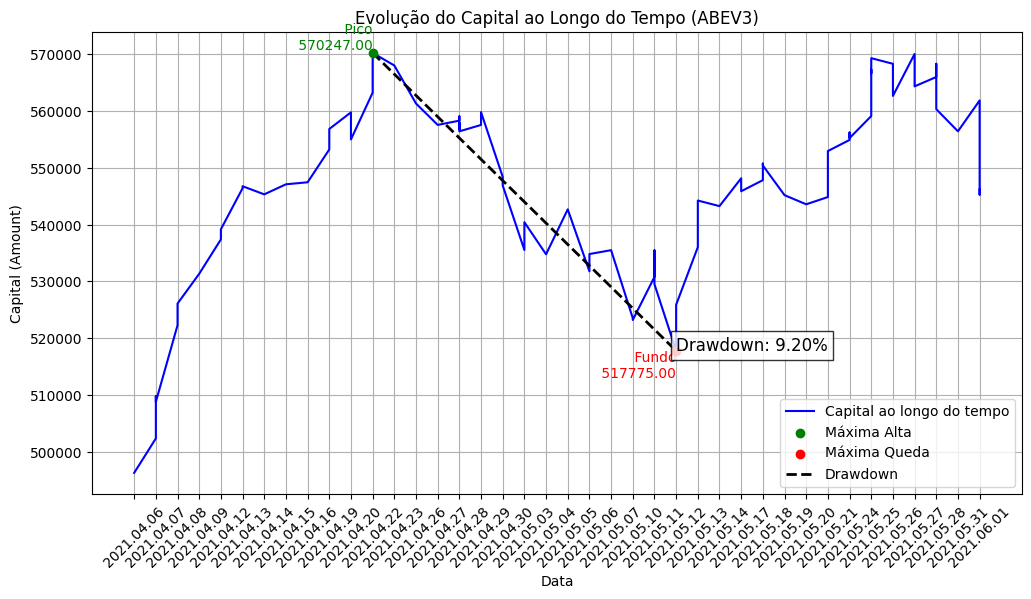

Final amount of BBDC4: 552177.9999999998


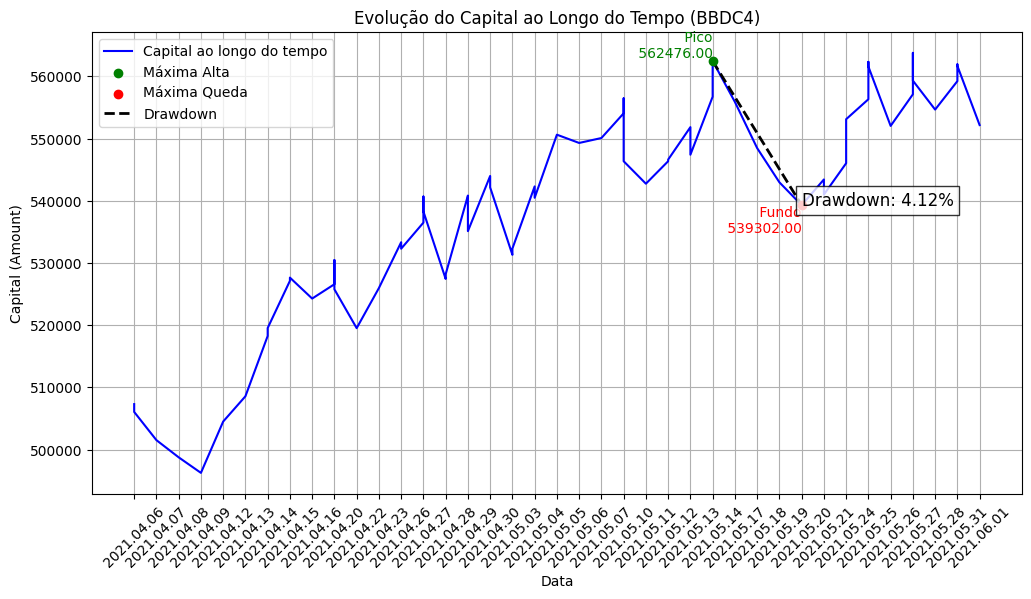

Final amount of EGIE3: 588905.9999999987


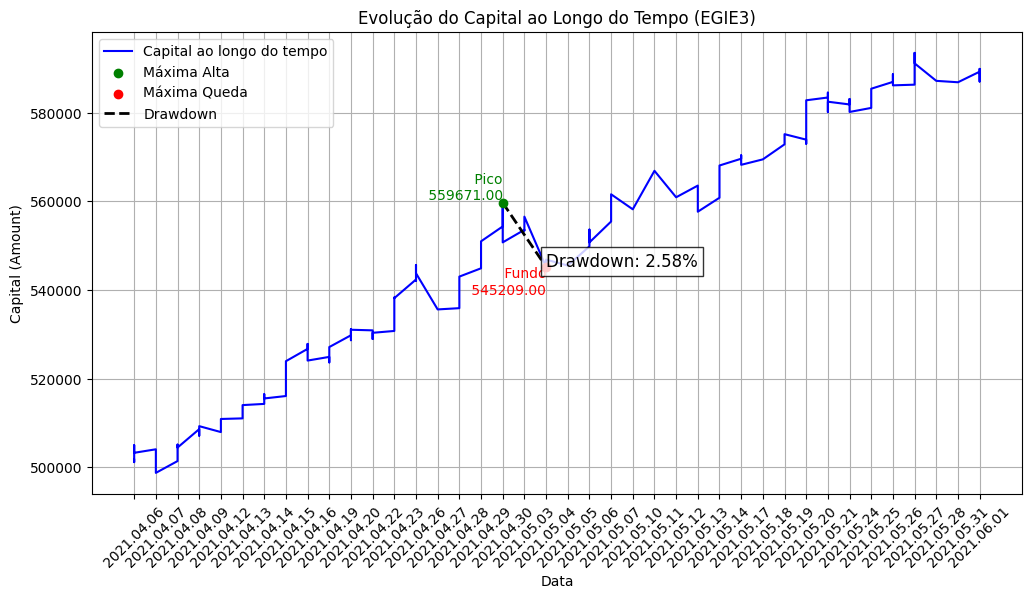

Final amount of ITUB4: 494935.99999999936


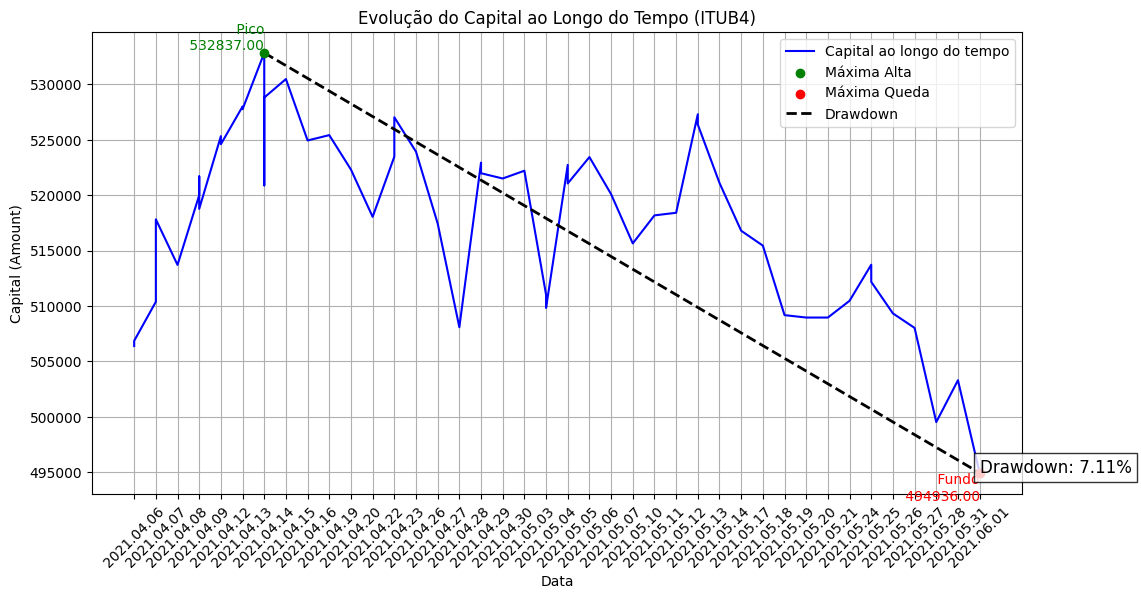

Final amount of JBSS3: 503938.9999999998


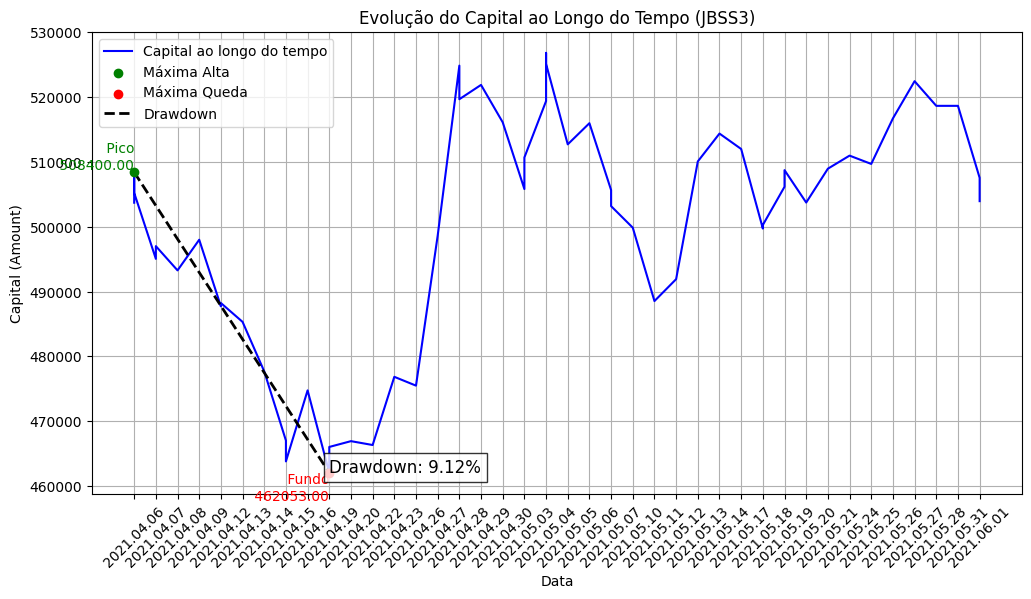

Final amount of PETR4: 543560.0000000002


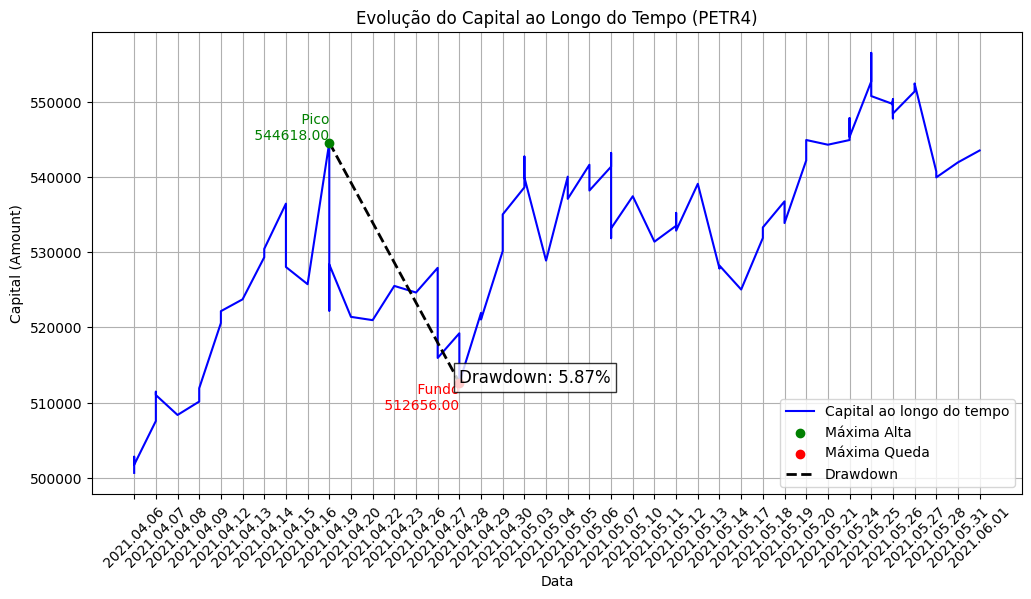

Final amount of VALE3: 529570.0


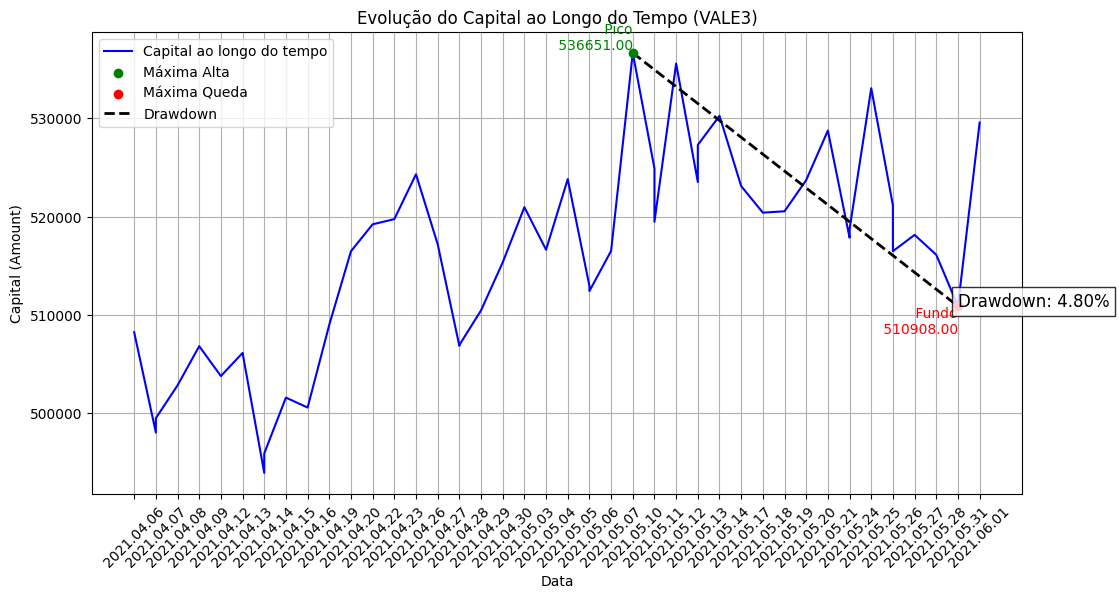

In [15]:
fundos = ['ABEV3', 'BBDC4','EGIE3', 'ITUB4', 'JBSS3', 'PETR4', 'VALE3']
for fundo in fundos:
    predictions = readPrevision(fundo)

    df = pd.read_csv(f'../Data/{fundo}_M15.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    initialDf = getPeriod2(df, TEST_BEGIN, TEST_END)
    
    resultados = []
    # Obtendo os valores mínimo e máximo da incerteza para o dataframe atual
    min_uncertainty = predictions["uncertainty_mean"].min()
    max_uncertainty = predictions["uncertainty_mean"].max()

    # Definindo um passo dinâmico (5% da diferença total)
    steps = np.linspace(min_uncertainty, max_uncertainty, num=20)
    steps = np.append(steps, 0)

    testPetr, tradedDays = runStrategy(predictions, initialDf, 500000, 0.02, 0.01, False, 0)

    if not testPetr.empty:
        finalAmount = testPetr.tail(1)['Amount'].iloc[0]
        acuracia = round(100 * len(testPetr[testPetr['profit'] > 0].index) / len(testPetr.index), 2)
    else:
        finalAmount = 500000
        acuracia = 0

    DDDF, maxDD = calculateDrawdown(testPetr)
    print(f"Final amount of {fundo}: {finalAmount}")
    plot_amount_curve(testPetr, DDDF, fundo)